# The London Railway Network

The cell below defines the abstract class whose API you will need to impement. Do NOT modify it.

In [1]:
# DO NOT MODIFY THIS CELL

from abc import ABC, abstractmethod  

class AbstractLondonRailwayMapper(ABC):
    
    # constructor
    @abstractmethod
    def __init__(self):
        pass           
        
    # data initialisation
    @abstractmethod
    def loadStationsAndLines(self):
        pass

    # returns the minimum number of stops to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # numStops : int
    @abstractmethod
    def minStops(self, fromS, toS):     
        numStops = -1
        return numStops    
    
    # returns the minimum distance in miles to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # minDistance : float
    @abstractmethod
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        return minDistance
    
    # given an unordered list of station names, returns a new railway line 
    # (represented as a list of adjacent station names), connecting all such stations 
    # and such that the sum of the distances (in miles) between adjacent stations is minimised
    # inputList : set<str>
    # outputList : list<str>
    @abstractmethod
    def newRailwayLine(self, inputList):
        outputList = []
        return outputList

Use the cell below to define any data structure and auxiliary python function you may need. Leave the implementation of the main API to the next code cell instead.

In [146]:
# ADD YOUR DATA STRUCTURE DEFINITIONS AND HELPER CODE HERE
#### Data Structures ####

from math import sqrt,cos, sin, radians, sqrt, atan2, pi
from matplotlib import pyplot as plt

def harvensineDistance(lat1, lng1, lat2, lng2):
    earthRadius = 3958.7613322984894 # earth's radius in miles
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lng2 = radians(lng2)
    lng1 = radians(lng1)

    dLat = lat2-lat1;
    dLng = lng2-lng1;
    a = sin(dLat/2) * sin(dLat/2) + cos(lat1) * cos(lat2) * sin(dLng/2) * sin(dLng/2);
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return earthRadius * c

class PQ:
    """
    Min-Oriented Prioirty Queue implemented with binary heap
    """

    def __init__(self):
        self.values = []
    
    def insert(self, value):
        # inserts new value at the very end and swim up if the value is less than the value above in the heap
        self.values.append(value)
        self.__swim_up(len(self.values) - 1)

    def delMin(self):

        if len(self.values) == 0: 
            return None

        # swap the first and last element of the values
        self.swap(0, len(self.values) - 1)
        output = self.values.pop()
        
        # sink the new swapped value that is at the top of the heap down
        self.__sink(0)
        
        return output

    def size(self):
        return len(self.values)
    
    def contains(self, targetValue):
        """
        Naive check to see if the value is inside by going through all the values inside the heap
        """
        for value in self.values:
            if value == targetValue:
                return True
        return False

    def isEmpty(self):
        return self.size() == 0


    def __sink(self, targetIndex):
        
        queueSize = len(self.values)


        while True:
            leftIndex = 2 * targetIndex + 1
            rightIndex = 2 * targetIndex + 2

            smaller = leftIndex

            if rightIndex < queueSize and self.values[rightIndex] < self.values[smaller]:
                smaller = rightIndex
            
            # needs to be >= here because the case of just two values
            if leftIndex >= queueSize or self.values[smaller] > self.values[targetIndex]:
                break

            self.swap(smaller, targetIndex)
            targetIndex = smaller

    def decreaseKey(self, targetValue, priority):
            """
            Decrease the priority of an existing value inside the queue
            
            This is used when the value is already inside the queue,
            instead of adding an extra item to the queue decrease the existing one instead
            """
            index = 0
            for value in self.values:
                if value == targetValue:
                    value.priority = priority
                    self.__swim_up(index)
                    # self.__sink(index)
                index += 1


    def __swim_up(self, targetIndex):
        parent_index = (targetIndex - 1) // 2

        while self.values[targetIndex] < self.values[parent_index] and targetIndex > 0:

            self.swap(parent_index, targetIndex)

            targetIndex = parent_index
            parent_index = (targetIndex - 1) // 2


    def swap(self, firstIndex, secondIndex):
        tmp = self.values[firstIndex]
        self.values[firstIndex] = self.values[secondIndex]
        self.values[secondIndex] = tmp


class NoDupePQ(PQ):

    def __init__(self):

        super().__init__()
        self.pointers = {}

    def insert(self, value):
        
        if self.contains(value.name):
            return False

        self.pointers[value.name] = len(self.values) + 1
        super().insert(value)
        return True

    def delMin(self):
        output = super().delMin()

        if output is not None:
            self.pointers.pop(output.name)

        return output


    def contains(self, targetValue):
        return self.pointers.get(targetValue) is not None     
 
    def swap(self, firstIndex, secondIndex):
        firstItemName = self.values[firstIndex].name
        secondItemName = self.values[secondIndex].name

        self.pointers[firstItemName], self.pointers[secondItemName] = self.pointers[secondItemName], self.pointers[firstItemName]

        super().swap(firstIndex, secondIndex)
        
class PQItem:
    """
    Wrapper Data type to facilitate storing value, where the value is not necessarily its weight
    
    ie, (any, 3) the value is anything, but the weight would be 3, useful for string vertex id and the value to go 
    to it
    
    """
    def __init__(self, name, priority):
        self.name = name
        self.priority = priority
    
    def __eq__(self, name):
        return self.name == name
    
    def __ge__(self, other):
        return self.priority >= other.priority

    def __gt__(self, other):
        return self.priority > other.priority
    
    def __le__(self, other):
        return self.priority <= other.priority
    
    def __lt__(self, other):
        return self.priority < other.priority

class Graph:
    """
    Adjacency List Graph Representation
    """
    def __init__(self, V):
        self.V = V
        self.adj = []
        for _ in range (0, V):
            self.adj.append([])

    def addEdge(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        self.adj[v].append(e)
        # self.adj[w].append(e)
        # we have to swap here because we have to relax its outgoing edges, 
        # if we don't swap the direction around it would relax the wrong end
        # i.e vertex 0 has edge 0 -> 1, but vertex 1 would also has edge 0 -> 1 if we don't swap it around
        self.adj[w].append(e.swap())

    def adjacencies(self, v):
        return self.adj[v]



class Edge:
    """
    Edge Representation for the graph
    
    Overwritten the comparison methods to use the edge's weight
    for ease of comparing when added to a priority queue
    
    """
    def __init__(self, v, w, weight):
        self.v = v
        self.w = w
        self.weight = weight

    def endPoint(self):
        return self.v

    def otherEndPoint(self, vertex):
        if vertex == self.v:
            return self.w
        return self.v

    def same(self, e):
        return self.v == e.endPoint() and self.w == e.otherEndPoint(e.endPoint()) and self.weight == e.getWeight()

    def getWeight(self):
        return self.weight

    def swap(self):
        return Edge(self.w, self.v, self.weight)
    
    def __str__(self):
        return f"v: {self.v}, w: {self.w}, weight: {self.weight}"
    
    def __eq__(self, other):
        return self.weight == other.weight
    
    def __ge__(self, other):
        return self.weight >= other.weight

    def __gt__(self, other):
        return self.weight > other.weight
    
    def __le__(self, other):
        return self.weight <= other.weight
    
    def __lt__(self, other):
        return self.weight < other.weight
    
class Queue():
    def __init__(self):
        self.queue = []
    
    def isEmpty(self):
        return self.queue == []
    
    def enqueue(self, item):
        self.queue.append(item)
    
    def dequeue(self):
        return self.queue.pop(0)
    
    def size(self):
        return len(self.queue)
    
class StationInfo:

    def __init__(self, station_id, name, lat, lng):
        self.station_id = station_id
        self.name = name
        self.lat = float(lat)
        self.lng = float(lng)
    
    def getName(self):
        return self.name

    def __str__(self):
        return f"station_id: {self.station_id}, latitude: {self.lat}, longitude: {self.lng}"

In [150]:
#### Algorithms ####

class BFS:
    """
    Breath-First-Search Algorithm
    """
    def __init__(self, G, s):
        self.starting = s
        self.distToSource = [-1 for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range(0, G.V)]
        self.__bfs(G, s)

    def __bfs(self, G, s):
        q = Queue()
        q.enqueue(s)
        self.distToSource[s] = 0
        while(not q.isEmpty()):
            v = q.dequeue()
            
            self.__traverseEdges(q, v, G)
                    
    def __traverseEdges(self,q, v, G):
        for w in G.adjacencies(v):
            
            index = w.otherEndPoint(v)
            
            if (self.distToSource[index] == -1):
                
                q.enqueue(index)
                self.distToSource[index] = self.distToSource[v] + 1
                self.edgeTo[index] = v
    
    def hasPathTo(self, v):
        return self.distToSource[v] != -1
    
    def pathTo(self, v):
        # Construct the path back to origin, useful for debugging to see if the output is correct
        if (not self.hasPathTo(v)): return None

        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path


    def lengthTo(self, v):
        # Get total weight from origin to v Vertex
        if (not self.hasPathTo(v)): return None

        return self.distToSource[v] 

    
class DFS:
    """
    Depth-First-Search Algorithm
    """
    def __init__(self, G, s, names):
        self.path = []
        self.x = []
        self.y = []
        self.names = names
        self.score = 0
        self.starting = s
        self.marked = [False for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range (0, G.V)]
        self.path.append(self.names[s].getName())
        self.x.append(self.names[s].lat)
        self.y.append(self.names[s].lng)
        self.previousPoint = self.names[s]
        self.__dfs(G,s)
    
    def __dfs(self, G, v):
        self.marked[v] = True
        
        for w in G.adjacencies(v):
            
            currentPoint = w.otherEndPoint(w.endPoint())
            
            if (not self.marked[currentPoint]):
                
                self.path.append(self.names[currentPoint].getName())
                self.score += harvensineDistance(self.previousPoint.lat, self.previousPoint.lng, self.names[currentPoint].lat, self.names[currentPoint].lng)
                self.previousPoint = self.names[currentPoint]
                self.x.append(self.names[currentPoint].lat)
                self.y.append(self.names[currentPoint].lng)
                self.__dfs(G,currentPoint)
                self.edgeTo[currentPoint] = v
    
    def hasPathTo(self, v):
        return self.marked[v]

    # build the path backwards 
    def pathTo(self, v):
        if (not self.hasPathTo(v)): return None
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path   
    
    

class LazyPrimMST:
    """
    Generate the minimum spanning tree using Prim's algorithm
    """
    def __init__(self, G):
        self.marked = [False for v in range(0, G.V)]
        self.mst = Queue()
        self.pq = PQ()
        self.__visit(G, 0)
        self.minSpanTree = Graph(G.V)
        
        limit = G.V - 1
        self.__run(limit, G)
    
                
    def getGraph(self):
        return self.minSpanTree
    
    
    def __run(self, limit, G):
         while (not self.pq.isEmpty() and self.mst.size() < limit):
            e = self.pq.delMin()
            v = e.endPoint()
            w = e.otherEndPoint(v)

            if self.marked[v] and self.marked[w]:
                continue
            
            # generate a graph and enqueueing the edge
            # so we do not have to loop through the edges again to create
            # the graph
            self.minSpanTree.addEdge(e)
            self.mst.enqueue(e)

            if not self.marked[v]:
                self.__visit(G, v)
            
            if not self.marked[w]:
                self.__visit(G, w)
    
    
    def __visit(self, G, v):
        self.marked[v] = True

        for e in G.adjacencies(v):
            if not self.marked[e.otherEndPoint(v)]:
                self.pq.insert(e)

class Dijkstra:

    def __init__(self, G, s, withDecreaseKey = False):
        self.withDecreaseKey = withDecreaseKey
        self.edgeTo = [None for v in range (0, G.V)]
        # -1 for infinity since weight cannot be negative
        self.distTo = [-1 for v in range(0, G.V)]
        self.distTo[s] = 0

        if withDecreaseKey:
            self.pq = NoDupePQ()
        else:
            self.pq = PQ()
        
        self.pq.insert(PQItem(s, 0))
        self.starting = s

        while not self.pq.isEmpty():
            v = self.pq.delMin().name
            for e in G.adjacencies(v):
                self.__relax(e)

    def __relax(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        # print(w)
        if self.distTo[w] > self.distTo[v] + e.getWeight() or self.distTo[w] == -1:
            self.distTo[w] = self.distTo[v] + e.getWeight()
            self.edgeTo[w] = e
            
            # small optimisation to not just add in a new edge
            # since Dijkstra has to loop through all the edges added to the priority queue
            # tested that dijkstra without decrease-key is actually faster in practice, than optimising the
            # amounts in the priority queue
            if self.withDecreaseKey:
                if self.pq.contains(w):
                    self.pq.decreaseKey(w, self.distTo[w])
                else:
                    self.pq.insert(PQItem(w, self.distTo[w]))
            else:
                self.pq.insert(PQItem(w, self.distTo[w]))

    def hasPathTo(self, v):
        return self.distToSource[v] != -1
    

    def pathTo(self, v):
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x].endPoint()
        path.append(self.starting)
        return path

    def lengthTo(self, v):
        return self.distTo[v] 
    
class TwoApprox:
    """
    Two-Approximation algorithm
    
    Generate complete graph from points and dictionaries with lat, lng info passed
    
    Generate minum spanning tree and run DFS to generate the eulerian path
    
    """
    def __init__(self, selected, stations):
        
        completeGraph, selectedStations = self.__generateCompleteGraph(selected, stations)
        mst = LazyPrimMST(completeGraph).getGraph()

        result = DFS(mst, 0, selectedStations)
        self.result = result
    
    def getPath(self):
        return self.result.path, self.result.x, self.result.y, self.result.score
    
    
    def __generateCompleteGraph(self, selected, stations):
        selectedStations = []
        
        # get all selected station names and added them to selectedStations list of StationInfo
        for stationName in selected:
            selectedStations.append(stations[stationName])
        
        newGraph = Graph(len(selectedStations))
        
        self.__createCompleteGraph(selectedStations, stations, newGraph)
        
        return newGraph, selectedStations
    
    
    def __euclideanDistance(self, lat1, lng1, lat2, lng2):
        return sqrt((lat1-lat2) ** 2 + (lng1-lng2) ** 2)

    def __createCompleteGraph(self, selectedStations, stations, graph):
        # calculate euclidean distance between the stations and add the edge to the graph for all
        # vertices
        
        addedStations = []
        for index, currentStation in enumerate(selectedStations):
            
            for createdStationIndex, createdStation in enumerate(addedStations):
                
                distance = self.__euclideanDistance(addedStations[createdStationIndex].lat, addedStations[createdStationIndex].lng, currentStation.lat, currentStation.lng)
                edge = Edge(index, createdStationIndex, distance)
                graph.addEdge(edge)
                
            addedStations.append(currentStation)
            
class Christofides:
    def __init__(self, selected, stations):
        
        completeGraph, selectedStations = self.__generateCompleteGraph(selected, stations)
        self.selectedStations = selectedStations
        self.mst = LazyPrimMST(completeGraph).getGraph()
        self.minWeightMaximalMatchings(self.mst)
        result = DFS(self.mst, 0, selectedStations)
        self.result = result
        
        
        
    def __getOddVertices(self, G):
        oddVertices = []
        for v in range(G.V):
            if len(G.adjacencies(v)) % 2 != 0:
                oddVertices.append(v)
        return oddVertices
    
    def minWeightMaximalMatchings(self, G):
        oddVertices = self.__getOddVertices(G)
        marked = {}
        
        pq = PQ()
        
        for i in range(0, len(oddVertices) - 1):
            for j in range(i + 1, len(oddVertices)):
                pq.insert(Edge(i, j, self.distanceStation(i, j)))
        
        targetAmount = len(oddVertices) // 2
        
        addedEdges = 0
        x = []
        y = []
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        while addedEdges < targetAmount and not pq.isEmpty():
            
            nextEdge = pq.delMin()
            
            if marked.get(nextEdge.endPoint()) is None and marked.get(nextEdge.otherEndPoint(nextEdge.endPoint())) is None:
                
                marked[nextEdge.endPoint()] = True
                marked[nextEdge.otherEndPoint(nextEdge.endPoint())] = True
                self.mst.addEdge(nextEdge)
                
                x.append(self.selectedStations[nextEdge.endPoint()].lat)
                y.append(self.selectedStations[nextEdge.endPoint()].lng)
                
                x.append(self.selectedStations[nextEdge.otherEndPoint(nextEdge.endPoint())].lat)
                y.append(self.selectedStations[nextEdge.otherEndPoint(nextEdge.endPoint())].lng)
                
                ax.plot(x,y, 'r-')
                
                addedEdges += 1
                


 
        plt.show()
        
    
    def distanceStation(self, firstStationId, secondStationId):
        firstStation = self.selectedStations[firstStationId]
        secondStation = self.selectedStations[secondStationId]
        
        return self.__euclideanDistance(firstStation.lat,firstStation.lng, secondStation.lat, secondStation.lng)
            
    
    def __euclideanDistance(self, lat1, lng1, lat2, lng2):
        return sqrt((lat1-lat2) ** 2 + (lng1-lng2) ** 2)
    
    def getPath(self):
        return self.result.path, self.result.x, self.result.y, self.result.score
    
    
    def __createCompleteGraph(self, selectedStations, stations, graph):
        # calculate euclidean distance between the stations and add the edge to the graph for all
        # vertices
        
        addedStations = []
        for index, currentStation in enumerate(selectedStations):
            
            for createdStationIndex, createdStation in enumerate(addedStations):
                
                distance = self.__euclideanDistance(addedStations[createdStationIndex].lat, addedStations[createdStationIndex].lng, currentStation.lat, currentStation.lng)
                edge = Edge(index, createdStationIndex, distance)
                graph.addEdge(edge)
                
            addedStations.append(currentStation)
    
    
    
    def __generateCompleteGraph(self, selected, stations):
        selectedStations = []
        
        # get all selected station names and added them to selectedStations list of StationInfo
        for stationName in selected:
            selectedStations.append(stations[stationName])
        
        newGraph = Graph(len(selectedStations))
        
        self.__createCompleteGraph(selectedStations, stations, newGraph)
        
        return newGraph, selectedStations
        

Use the cell below to implement the requested API.

In [154]:
import csv

class LondonRailwayMapper(AbstractLondonRailwayMapper):
    
    def __init__(self):
        self.stations = {}
        self.stationNames = []
        
    def loadStationsAndLines(self):
        self.__loadStations()
        self.__loadLines()

    def __loadStations(self):
        with open('londonstations.csv') as file:
            
            reader = csv.reader(file, delimiter='\n')
            first = True
            id_counter = 0
            for row in reader:
                
                if first:
                    first = False
                    continue
                    
                rowContent = row[0].split(',')
                self.stations[rowContent[0]] = StationInfo(id_counter, rowContent[0], rowContent[1], rowContent[2])
                self.stationNames.append(rowContent[0])
                id_counter+=1

            self.graph = Graph(id_counter + 1)

    def __loadLines(self):
        with open('londonrailwaylines.csv') as file:
            
            reader = csv.reader(file, delimiter='\n')
            first = True

            for row in reader:
                
                if first:
                    first = False
                    continue
                    
                rowContent = row[0].split(',')
                fromStation = self.stations[rowContent[1]]
                toStation = self.stations[rowContent[2]]
                
                distanceBetweenStation = harvensineDistance(fromStation.lat,fromStation.lng, toStation.lat, toStation.lng)
                
                self.graph.addEdge(Edge(fromStation.station_id, toStation.station_id, distanceBetweenStation)) 
    

    def minStops(self, fromS, toS):     
         return BFS(self.graph, self.stations[fromS].station_id).lengthTo(self.stations[toS].station_id)
    
    
    
    def minDistance(self, fromS, toS):
        result = Dijkstra(self.graph, self.stations[fromS].station_id)
        return result.lengthTo(self.stations[toS].station_id)
    
    
    
    
    def newRailwayLine(self, inputList):
        path, x, y, score = Christofides(inputList, self.stations).getPath()
        print(len(path))
        print("the score is below")
        print(score)
        
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

        ax.plot(x,y, 'o-')
        plt.show()
        
        return path

Use the cell below for all python code needed to test the `LondonRailwayMapper` class above.

v: 1, w: 0, weight: 0.1021216345449221
v: 2, w: 0, weight: 0.05930683190312754
v: 2, w: 1, weight: 0.042900521799106923
v: 3, w: 0, weight: 0.06092666731443699
v: 3, w: 1, weight: 0.0422141050150456
v: 3, w: 2, weight: 0.00519400251120033
v: 4, w: 0, weight: 0.12965849285846479
v: 4, w: 1, weight: 0.027803433667847953
v: 4, w: 2, weight: 0.0706053943407813
v: 4, w: 3, weight: 0.07001613445675736
v: 5, w: 0, weight: 0.24333609315833848
v: 5, w: 1, weight: 0.14457967439666441
v: 5, w: 2, weight: 0.1850559140780026
v: 5, w: 3, weight: 0.18266981561514628
v: 5, w: 4, weight: 0.12079097037668636
v: 6, w: 0, weight: 0.17733646550951115
v: 6, w: 1, weight: 0.0948510212148997
v: 6, w: 2, weight: 0.12479874318913226
v: 6, w: 3, weight: 0.12091351925734833
v: 6, w: 4, weight: 0.08473514538531386
v: 6, w: 5, weight: 0.08211543902595728
v: 7, w: 0, weight: 0.18825325867373852
v: 7, w: 1, weight: 0.09098440885442795
v: 7, w: 2, weight: 0.13029227376465563
v: 7, w: 3, weight: 0.12773116854808594
v: 

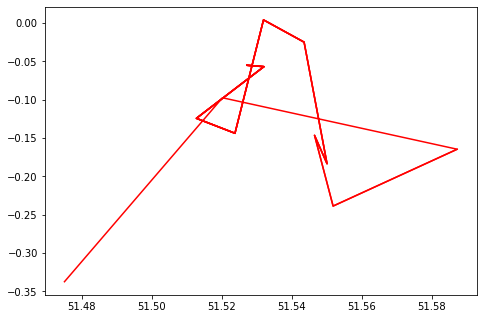

24
the score is below
68.42459077854082


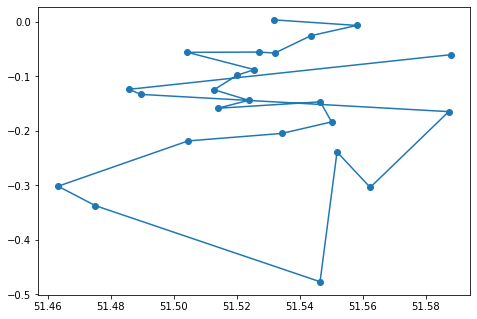

In [155]:
import timeit

# ADD YOUR TEST CODE HERE
stationsList = ["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"]


newLine = testMapper.newRailwayLine(stationsList)


The cell below exemplifies the test code I will invoke on your submission. Do NOT modify it. 

v: 23, w: 458, weight: 0.4991723167616763
v: 111, w: 191, weight: 0.1272608627065301
v: 181, w: 358, weight: 0.32623066749333607
v: 191, w: 597, weight: 0.48609014762624303
v: 255, w: 636, weight: 0.6467627099801703
v: 260, w: 309, weight: 1.120637845082525
v: 303, w: 443, weight: 0.8951059319856031
v: 309, w: 497, weight: 0.7834339482909563
v: 315, w: 350, weight: 0.5105596526441676
v: 327, w: 184, weight: 0.5257915158015865
v: 350, w: 596, weight: 0.4878800682016493
v: 358, w: 23, weight: 0.287726945557465
v: 398, w: 604, weight: 0.7967690725960656
v: 416, w: 427, weight: 0.4895583249825813
v: 417, w: 181, weight: 0.42613385897378997
v: 427, w: 111, weight: 0.3940987925803919
v: 443, w: 315, weight: 0.4690102358476831
v: 458, w: 416, weight: 0.6241801642714013
v: 497, w: 398, weight: 0.6240998277408039
v: 525, w: 255, weight: 0.9365651952828049
v: 596, w: 417, weight: 0.6165160411386822
v: 597, w: 327, weight: 0.28483960952003445
v: 604, w: 525, weight: 1.0534733875111413
v: 636, w: 

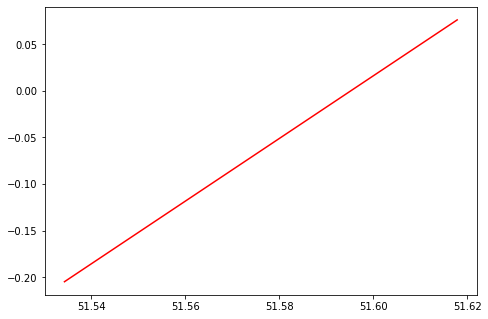

6
the score is below
18.876400119104584


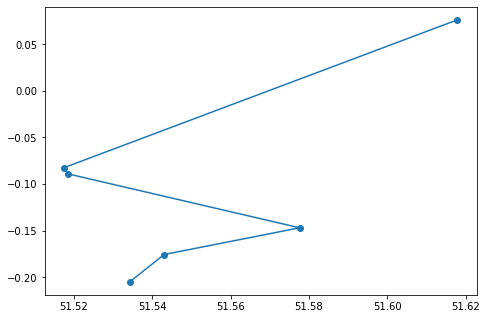



Station list ['Queens Park', 'Chigwell', 'Moorgate', 'Swiss Cottage', 'Liverpool Street', 'Highgate']
New station line ['Queens Park', 'Swiss Cottage', 'Highgate', 'Moorgate', 'Liverpool Street', 'Chigwell']
Total track length from Queens Park to Chigwell : 18.71004286299515 miles
Execution time newLine: 0.275
v: 1, w: 0, weight: 0.1021216345449221
v: 2, w: 0, weight: 0.05930683190312754
v: 2, w: 1, weight: 0.042900521799106923
v: 3, w: 0, weight: 0.06092666731443699
v: 3, w: 1, weight: 0.0422141050150456
v: 3, w: 2, weight: 0.00519400251120033
v: 4, w: 0, weight: 0.12965849285846479
v: 4, w: 1, weight: 0.027803433667847953
v: 4, w: 2, weight: 0.0706053943407813
v: 4, w: 3, weight: 0.07001613445675736
v: 5, w: 0, weight: 0.24333609315833848
v: 5, w: 1, weight: 0.14457967439666441
v: 5, w: 2, weight: 0.1850559140780026
v: 5, w: 3, weight: 0.18266981561514628
v: 5, w: 4, weight: 0.12079097037668636
v: 6, w: 0, weight: 0.17733646550951115
v: 6, w: 1, weight: 0.0948510212148997
v: 6, w: 

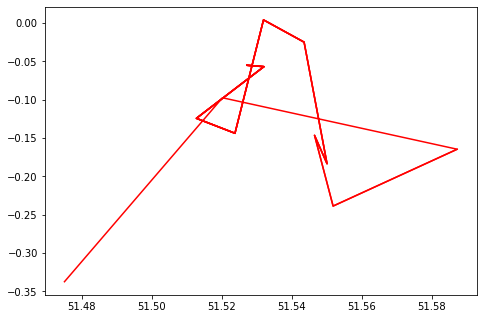

24
the score is below
68.42459077854082


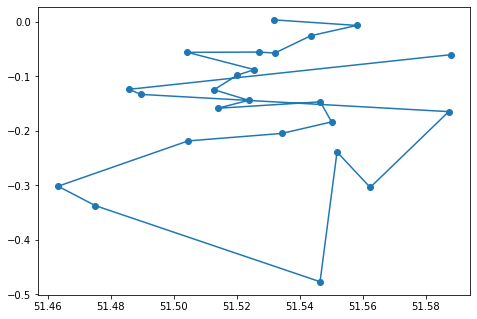



Station list ['Abbey Road', 'Barbican', 'Bethnal Green', 'Cambridge Heath', 'Covent Garden', 'Dollis Hill', 'East Finchley', 'Finchley Road and Frognal', 'Great Portland Street', 'Hackney Wick', 'Isleworth', 'Kentish Town West', 'Leyton', 'Marble Arch', 'North Wembley', 'Old Street', 'Pimlico', 'Queens Park', 'Richmond', 'Shepherds Bush', 'Tottenham Hale', 'Uxbridge', 'Vauxhall', 'Wapping']
New station line ['Abbey Road', 'Leyton', 'Hackney Wick', 'Cambridge Heath', 'Bethnal Green', 'Wapping', 'Old Street', 'Barbican', 'Covent Garden', 'Great Portland Street', 'Marble Arch', 'Kentish Town West', 'Finchley Road and Frognal', 'Queens Park', 'Shepherds Bush', 'Richmond', 'Isleworth', 'Uxbridge', 'Dollis Hill', 'North Wembley', 'East Finchley', 'Pimlico', 'Vauxhall', 'Tottenham Hale']
Total track length from Abbey Road to Tottenham Hale : 4.763530994850844 miles
Execution time newLine: 0.309


In [153]:
# DO NOT MODIFY THIS CELL

import timeit

testMapper = LondonRailwayMapper()

#
# testing the loadStationsAndLines() API 
#
starttime = timeit.default_timer()
testMapper.loadStationsAndLines()
endtime = timeit.default_timer()
print("\nExecution time to load:", round(endtime-starttime,3))

#
# testing the minStops() and minStops() API on a sample of from/to station pairs  
#
fromList = ["Baker Street", "Epping", "Canonbury", "Vauxhall"]
toList = ["North Wembley", "Belsize Park", "Balham", "Leytonstone"]

for i in range(len(fromList)):
    starttime = timeit.default_timer()
    stops = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("\nExecution time minStops:", round(endtime-starttime,3))

    starttime = timeit.default_timer()
    dist = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("Execution time minDistance:", round(endtime-starttime,3))

    print("From", fromList[i], "to", toList[i], "in", stops, "stops and", dist, "miles")  
    
#
# testing the newRailwayLine() API on a small list of stations  
#
stationsList = ["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

#
# testing the newRailwayLine() API on a big list of stations  
#
stationsList = ["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

In [141]:
for i in range(1,2):
    print(i)

1
